# Tutorial 2:  the `Agent` API

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/infer-actively/pymdp/blob/master/docs/notebooks/using_the_agent_class.ipynb)

*Author: Conor Heins*

This tutorial introduces the `Agent` class, the main API offered by `pymdp` that allows you to abstract away all the mathematical nuances involved in running active inference processes. All you have to do is build a generative model in terms of `A`, `B`, `C`, and `D` arrays, plug them into the `Agent()` constructor, and then start running active inference processes using the desired functions of the `Agent` class, like `self.infer_states()` and `self.infer_policies()`. 

We demonstrate the use of the `Agent` class by building an active inference agent to play a simple explore/exploit task, what we call the "epistemic 2-armed bandit". The task structure is identical to the "explore/exploit" task described in Smith et al. (2022): ["A Step-by-Step Tutorial on Active Inference Modelling and its Application to Empirical Data"](https://www.sciencedirect.com/science/article/pii/S0022249621000973). The task is a modified version of a classic multi-armed bandit problem, with particular changes that make it well suited to demonstrating the information-availing nature of active inference in discrete state spaces.

*Note*: When running this notebook in Google Colab, you may have to run `!pip install inferactively-pymdp` at the top of the notebook, before you can `import pymdp`. That cell is left commented out below, in case you are running this notebook from Google Colab.

In [1]:
# ! pip install inferactively-pymdp

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Define some auxiliary functions

Here are some plotting functions that will come in handy throughout the tutorial.

In [3]:
def plot_likelihood(matrix, title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()


def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

## **More complex generative models**

In this notebook we will build a more complicated generative model, with the following goals in mind:

1. Demonstrate the unique behavior of active inference agents, as opposed to other agent-based approaches to solving POMDPs (e.g. utility-maximization / reinforcement learning)

2. Provide a task example that is more relevant to decision-making research and computational psychiatry.

3. Take advantage of the functionalities of `pymdp`, especially the `Agent()` class, to abstract away all the mathematical operations involved with inference and planning under active inference.

Before we dive into specifying this generative model, we need to talk about _observation modalities_ and _hidden state factors_...


The data structure we use in `pymdp` to represent different hidden state factors and observation modalities is the `object array` (referred to in other contexts as 'arrays of arrays' or 'jagged/ragged arrays').

They are no different than standard numpy `ndarrays` (they can arbitrarily multidimensional shape), except for the fact that their contents are unrestricted in terms of type. Their `dtype` is `object`, which means that their elements can be any kind of Python data structure -- including other arrays!

In case you're coming from a  MATLAB background: these object arrays are the equivalent of cell arrays. 

In `pymdp`, we represent a multi-factor $\mathbf{B}$ array as an object array which has as many elements as there are hidden state factors. Therefore, each element `B[i]` of the object array contains the `B` matrix for hidden state factor `i`.

In [4]:
import pymdp
from pymdp import utils

## **Explore/exploit task with a epistemic two-armed bandit**

Now we're going to build a generative model for an active inference agent playing a two-armed bandit task. The [multi-armed bandit](https://en.wikipedia.org/wiki/Multi-armed_bandit) (or MAB) is a classic decision-making task that captures the core features of the the "explore/exploit tradeoff". The multi-armed bandit formulation is ubiquitous across problem spaces that require sequential decision-making under uncertainty -- this includes disciplines ranging from economics, neuroscience, machine learning, engineering all the way to advertising.

In the standard MAB problem formulation, an agent has must choose between mutually-exclusive alternatives (also known as 'arms') in order to maximize reward over time. The probability of reward depends on which arm the agent chooses. A common real-world analogy for a MAB problem is imagining a special slot machine with three possible levers to pull (rather than the usual one), where playing each lever has different probabilities of payoff (e.g. getting a winning combination of symbols or bonus). In fact, the 'standard' slot machine, which usually only only one lever, was historically referred to as a 'one-armed bandit' -- this was the direct ancestor of the name for the generic machine learning / decision-making problem class, the MAB. 

Crucially, MAB problems are interesting and difficult because in general, the reward statistics of each arm are unknown or only partially known. In a probabilistic or Bayesian context, an agent must therefore act based on _beliefs_ about the reward statistics, since they don't have perfect access to this information. 

The inherent partial-observability  of the ask creates a conflict between **exploitation** or choosing the arm that is _currently believed_ to be most rewarding, and **exploration** or gathering information about the remaining arms, in the hopes of discovering a potentially more rewarding option.

The fact that expected reward or utility is contextualized by _beliefs_ -- i.e. which arm is currently thought to be the most rewarding -- motivates the use of active inference in this context. This is because the key objective function for action-selection, the expected free energy $\mathbf{G}$, depends on the agent's beliefs about the world. And not only that, but expected free energy balances the desire to maximize rewards with the drive to resolve uncertainty about unknown parts of the agent's model. The more accurate the agent's beliefs are, the more faithfully decision-making can be guided by maximizing expected utility or rewards.

#### **MAB with an epistemic twist**

In the MAB formulation we'll be exploring in this tutorial, the agent must choose to play among two possible arms, each of which has unknown reward statistics. These reward statistics take the form of Bernoulli distributions over two possible reward outcomes: "Loss" and "Reward". However, one of the arms has probability $p$ of yielding "Reward"" and probabiliity $(1-p)$ of yielding "Loss". The other arm has swapped statistics. In this example, agent knows that the bandit has this general reward structure, except they don't know *which* of the two arms is the rewarding one (the arm where reward probability is $p$, assuming $p \in [0.5, 1]$).

However, we introduce an additional feature in the environment, that induces an explicit trade-off in decision-making between exploration (information-seeking) and exploitation (reward-seeking). In this special "epistemic bandit" problem, there is an additional action available to the agent, besides playing the two arms. We call this third action "Get Hint", and allows the agent to acquire information reveals (potentially probabilistically) which arm is the more rewarding one. There is a trade-off here, because by choosing to acquire the hint, the agent forgoes the possibility of playing an arm and thus the possibility of getting a reward at that moment. The mutual exclusivity of hint-acquisition and arm-playing imbues the system with an explore/exploit trade-off, which active inference is particularly equipped to handle, when compared to simple reinforcement learning schemes (e.g. epsilon-greedy reward maximization).



---

Specify the dimensionalities of the hidden state factors, the control factors, and the observation modalities

In [5]:
context_names = ['Left-Better', 'Right-Better']
choice_names = ['Start', 'Hint', 'Left Arm', 'Right Arm']

""" Define `num_states` and `num_factors` below """
num_states = [len(context_names), len(choice_names)]
num_factors = len(num_states)

context_action_names = ['Do-nothing']
choice_action_names = ['Move-start', 'Get-hint', 'Play-left', 'Play-right']

""" Define `num_controls` below """
num_controls = [len(context_action_names), len(choice_action_names)]

hint_obs_names = ['Null', 'Hint-left', 'Hint-right']
reward_obs_names = ['Null', 'Loss', 'Reward']
choice_obs_names = ['Start', 'Hint', 'Left Arm', 'Right Arm']

""" Define `num_obs` and `num_modalities` below """
num_obs = [len(hint_obs_names), len(reward_obs_names), len(choice_obs_names)]
num_modalities = len(num_obs)

### The `A` array
---

**Note**: Unlike in [Tutorial 1: Active inference from scratch](https://pymdp-rtd.readthedocs.io/en/latest/notebooks/active_inference_from_scratch.html), here we we will be building a more complex generative model more than one hidden state factor and observation modality. This leads to accordingly higher-dimensional `A` and `B` arrays. See [pymdp fundamentals](https://pymdp-rtd.readthedocs.io/en/latest/notebooks/pymdp_fundamentals.html) for more details on how we specify these high-dimensional arrays in `NumPy`.

In [6]:
""" Generate the A array """
A = utils.obj_array( num_modalities )

Fill out the hint modality, a sub-array of `A` which we'll call `A_hint`

<img src="https://drive.google.com/uc?export=view&id=1SqMp77NAmUa_oh925VURJ1Hyp8v_fXOj"/>



In [7]:
p_hint = 0.7 # accuracy of the hint, according to the agent's generative model (how much does the agent trust the hint?)

A_hint = np.zeros( (len(hint_obs_names), len(context_names), len(choice_names)) )

for choice_id, choice_name in enumerate(choice_names):

  if choice_name == 'Start':

    A_hint[0,:,choice_id] = 1.0
  
  elif choice_name == 'Hint':

    A_hint[1:,:,choice_id] = np.array([[p_hint,       1.0 - p_hint],
                                      [1.0 - p_hint,  p_hint]])
  elif choice_name == 'Left Arm':

    A_hint[0,:,choice_id] = 1.0
  
  elif choice_name == 'Right Arm':

    A_hint[0,:,choice_id] = 1.0
  
A[0] = A_hint

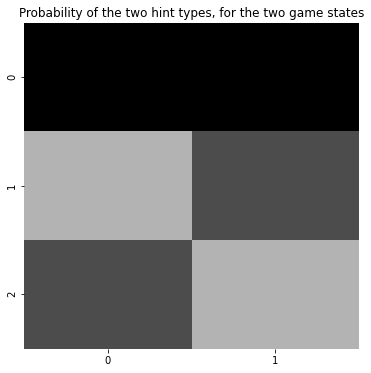

In [8]:
plot_likelihood(A[0][:,:,1], title_str = "Probability of the two hint types, for the two game states")

Fill out the reward modality, a sub-array of `A` which we'll call `A_rew`

<img src="https://drive.google.com/uc?export=view&id=155LAPZ9_aulJ3YYZwwlOWrEa6unabHht"/>

In [9]:
p_reward = 0.8 # probability of getting a rewarding outcome, if you are sampling the more rewarding bandit

A_reward = np.zeros((len(reward_obs_names), len(context_names), len(choice_names)))

for choice_id, choice_name in enumerate(choice_names):

  if choice_name == 'Start':

    A_reward[0,:,choice_id] = 1.0
  
  elif choice_name == 'Hint':

    A_reward[0,:,choice_id] = 1.0
  
  elif choice_name == 'Left Arm':

    A_reward[1:,:,choice_id] = np.array([ [1.0-p_reward, p_reward], 
                                        [p_reward, 1.0-p_reward]])
  elif choice_name == 'Right Arm':

    A_reward[1:, :, choice_id] = np.array([[ p_reward, 1.0- p_reward], 
                                         [1- p_reward, p_reward]])
  
A[1] = A_reward

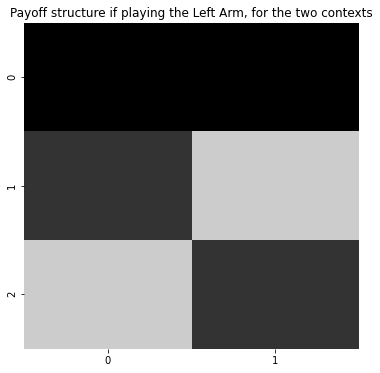

In [10]:
plot_likelihood(A[1][:,:,2], 'Payoff structure if playing the Left Arm, for the two contexts')

Fill out the choice observation modality, a sub-array of `A` which we'll call `A_choice`

<img src="https://drive.google.com/uc?export=view&id=1LGdGX0TgesvQ2HDnHMg42XHh0n6ZKnHw"/>


In [11]:
A_choice = np.zeros((len(choice_obs_names), len(context_names), len(choice_names)))

for choice_id in range(len(choice_names)):

  A_choice[choice_id, :, choice_id] = 1.0

A[2] = A_choice

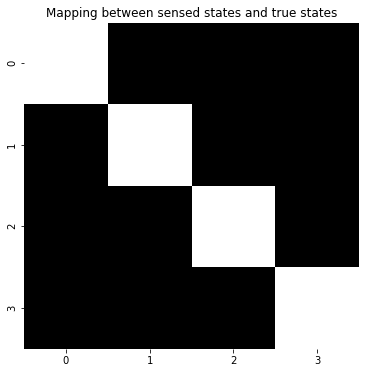

In [12]:
""" Condition on context (first hidden state factor) and display the remaining indices (outcome and choice state) """

plot_likelihood(A[2][:,0,:], "Mapping between sensed states and true states")

### The `B` array

In [13]:
B = utils.obj_array(num_factors)

 Fill out the context state factor dynamics, a sub-array of `B` which we'll call `B_context`

<img src="https://drive.google.com/uc?export=view&id=1_VvkCpRu1wWwEFiAJKnOGAGikd5KeiiE" width="600" height="300" />


In [14]:
B_context = np.zeros( (len(context_names), len(context_names), len(context_action_names)) )

B_context[:,:,0] = np.eye(len(context_names))

B[0] = B_context

Fill out the choice factor dynamics, a sub-array of `B` which we'll call `B_choice`

<img src="https://drive.google.com/uc?export=view&id=1qeuFvNIrJR7ldjpkrB6_jAp6JM3UhMw0"/>


In [15]:
B_choice = np.zeros( (len(choice_names), len(choice_names), len(choice_action_names)) )

for choice_i in range(len(choice_names)):
  
  B_choice[choice_i, :, choice_i] = 1.0

B[1] = B_choice

### The `C` vectors

In [16]:
""" Explain `obj_array_zeros` and how you don't have to populate them necessarily """
C = utils.obj_array_zeros(num_obs)

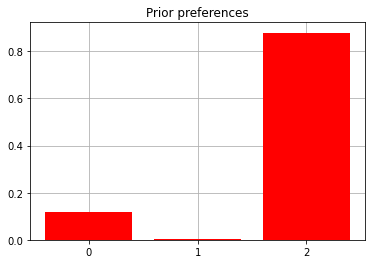

In [17]:
from pymdp.maths import softmax

C_reward = np.zeros(len(reward_obs_names))
C_reward[1] = -4.0 
C_reward[2] = 2.0 

C[1] = C_reward

plot_beliefs(softmax(C_reward), title_str = "Prior preferences")

### The `D` vectors

In [18]:
D = utils.obj_array(num_factors)

D_context = np.array([0.5,0.5])

D[0] = D_context

D_choice = np.zeros(len(choice_names))

D_choice[choice_names.index("Start")] = 1.0

D[1] = D_choice

print(f'Beliefs about which arm is better: {D[0]}')
print(f'Beliefs about starting location: {D[1]}')

Beliefs about which arm is better: [0.5 0.5]
Beliefs about starting location: [1. 0. 0. 0.]


## **Constructing an `Agent`**

In [19]:
from pymdp.agent import Agent

my_agent = Agent(A = A, B = B, C = C, D = D)

Define a class for the 2-armed bandit environment (AKA the _generative process_)

In [20]:
class TwoArmedBandit(object):

  def __init__(self, context = None, p_hint = 1.0, p_reward = 0.8):

    self.context_names = ["Left-Better", "Right-Better"]

    if context == None:
      self.context = self.context_names[utils.sample(np.array([0.5, 0.5]))] # randomly sample which bandit arm is better (Left or Right)
    else:
      self.context = context

    self.p_hint = p_hint
    self.p_reward = p_reward

    self.reward_obs_names = ['Null', 'Loss', 'Reward']
    self.hint_obs_names = ['Null', 'Hint-left', 'Hint-right']

  def step(self, action):

    if action == "Move-start":
      observed_hint = "Null"
      observed_reward = "Null"
      observed_choice = "Start"
    elif action == "Get-hint":
      if self.context == "Left-Better":
        observed_hint = self.hint_obs_names[utils.sample(np.array([0.0, self.p_hint, 1.0 - self.p_hint]))]
      elif self.context == "Right-Better":
        observed_hint = self.hint_obs_names[utils.sample(np.array([0.0, 1.0 - self.p_hint, self.p_hint]))]
      observed_reward = "Null"
      observed_choice = "Hint"
    elif action == "Play-left":
      observed_hint = "Null"
      observed_choice = "Left Arm"
      if self.context == "Left-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, 1.0 - self.p_reward, self.p_reward]))]
      elif self.context == "Right-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, self.p_reward, 1.0 - self.p_reward]))]
    elif action == "Play-right":
      observed_hint = "Null"
      observed_choice = "Right Arm"
      if self.context == "Right-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, 1.0 - self.p_reward, self.p_reward]))]
      elif self.context == "Left-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, self.p_reward, 1.0 - self.p_reward]))]
    
    obs = [observed_hint, observed_reward, observed_choice]

    return obs
  

Now we'll write a function that will take the agent, the environment, and a time length and run the active inference loop

In [21]:
def run_active_inference_loop(my_agent, my_env, T = 5):

  """ Initialize the first observation """
  obs_label = ["Null", "Null", "Start"]  # agent observes itself seeing a `Null` hint, getting a `Null` reward, and seeing itself in the `Start` location
  obs = [hint_obs_names.index(obs_label[0]), reward_obs_names.index(obs_label[1]), choice_obs_names.index(obs_label[2])]
  
  for t in range(T):
    qs = my_agent.infer_states(obs)
    plot_beliefs(qs[0], title_str = f"Beliefs about the context at time {t}")

    q_pi, efe = my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[1])

    choice_action = choice_action_names[movement_id]

    obs_label = my_env.step(choice_action)

    obs = [hint_obs_names.index(obs_label[0]), reward_obs_names.index(obs_label[1]), choice_obs_names.index(obs_label[2])]

    print(f'Action at time {t}: {choice_action}')
    print(f'Reward at time {t}: {obs_label[1]}')


Now all we have to do is define the two-armed bandit environment, choose the length of the simulation, and run the function we wrote above.


*   Try playing with the hint accuracy and/or reward statistics of the environment - remember this is _different_ than the agent's representation of the reward statistics (i.e. the agent's generative model, e.g. the A or B matrices).




Context: Right-Better


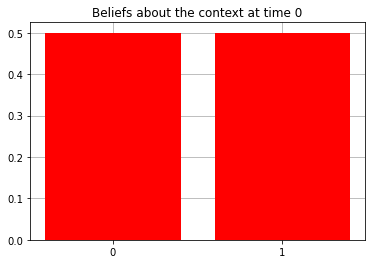

Action at time 0: Get-hint
Reward at time 0: Null


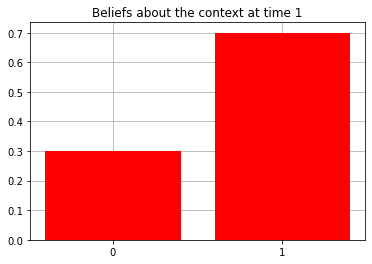

Action at time 1: Get-hint
Reward at time 1: Null


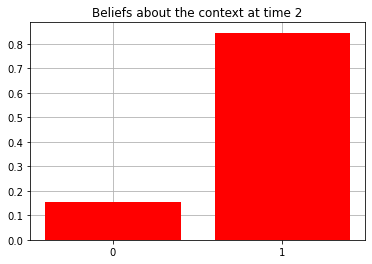

Action at time 2: Play-right
Reward at time 2: Reward


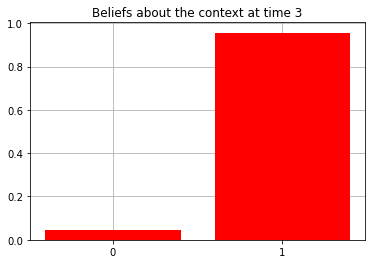

Action at time 3: Play-right
Reward at time 3: Reward


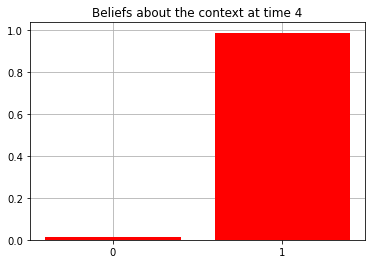

Action at time 4: Play-right
Reward at time 4: Loss


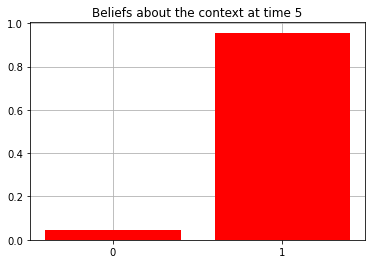

Action at time 5: Play-right
Reward at time 5: Reward


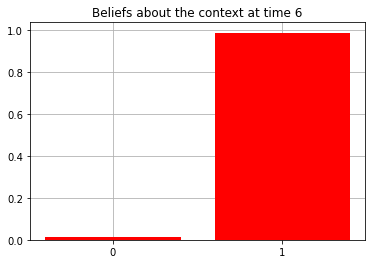

Action at time 6: Play-right
Reward at time 6: Loss


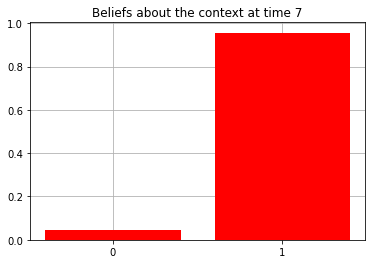

Action at time 7: Play-right
Reward at time 7: Reward


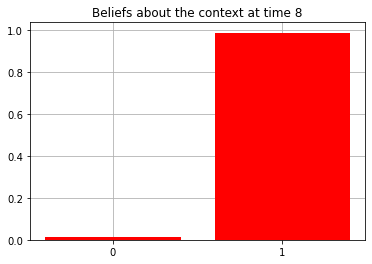

Action at time 8: Play-right
Reward at time 8: Reward


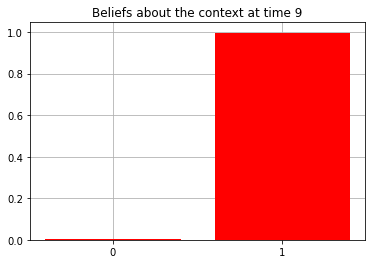

Action at time 9: Play-right
Reward at time 9: Reward


In [22]:
p_hint_env = 1.0 # this is the "true" accuracy of the hint - i.e. how often does the hint actually signal which arm is better. REMEMBER: THIS IS INDEPENDENT OF HOW YOU PARAMETERIZE THE A MATRIX FOR THE HINT MODALITY
p_reward_env = 0.7 # this is the "true" reward probability - i.e. how often does the better arm actually return a reward, as opposed to a loss. REMEMBER: THIS IS INDEPENDENT OF HOW YOU PARAMETERIZE THE A MATRIX FOR THE REWARD MODALITY
env = TwoArmedBandit(p_hint = p_hint_env, p_reward = p_reward_env)
print(f'Context: {env.context}')

T = 10

# my_agent = Agent(A = A, B = B, C = C, D = D) # in case you want to re-define the agent, you can run this again

run_active_inference_loop(my_agent, env, T = T)

Now let's try manipulating the agent's prior preferences over reward observations ($\mathbf{C}[1]$) in order to examine the tension between exploration and exploitation.

Context: Right-Better


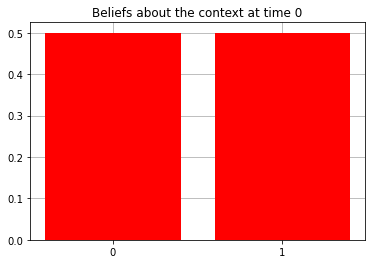

Action at time 0: Play-left
Reward at time 0: Loss


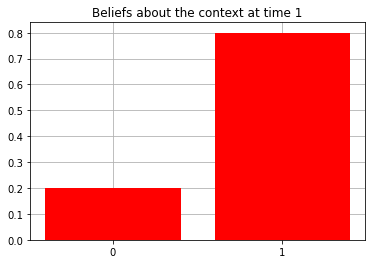

Action at time 1: Play-right
Reward at time 1: Loss


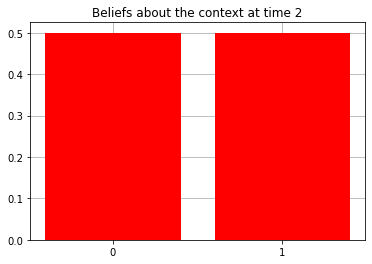

Action at time 2: Play-left
Reward at time 2: Loss


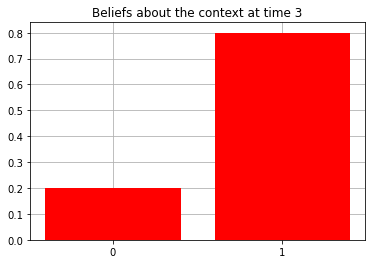

Action at time 3: Play-right
Reward at time 3: Reward


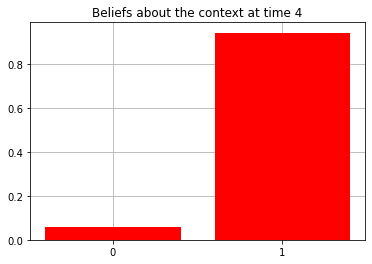

Action at time 4: Play-right
Reward at time 4: Reward


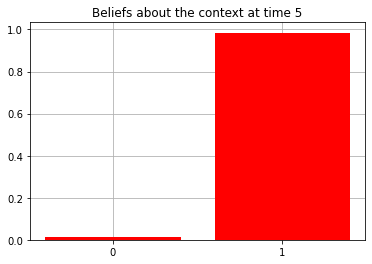

Action at time 5: Play-right
Reward at time 5: Reward


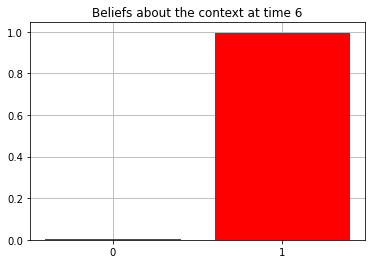

Action at time 6: Play-right
Reward at time 6: Loss


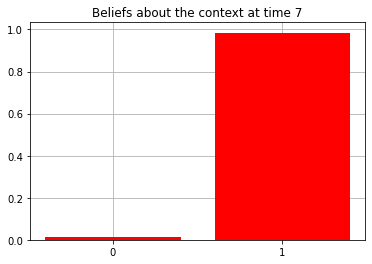

Action at time 7: Play-right
Reward at time 7: Reward


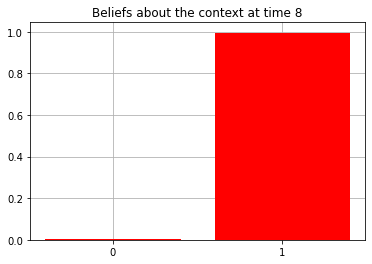

Action at time 8: Play-right
Reward at time 8: Reward


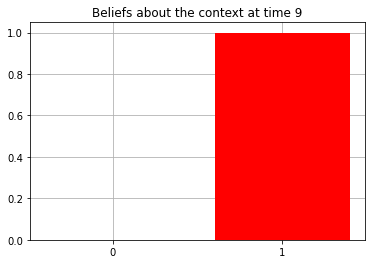

Action at time 9: Play-right
Reward at time 9: Reward


In [23]:
# change the 'shape' of the agent's reward function
C[1][1] = 0.0 # makes the Loss "less aversive" than before (higher prior prior probability assigned to seeing the Loss outcome). This should make the agent less risk-averse / willing to explore both arms, under uncertainty

my_agent = Agent(A = A, B = B, C = C, D = D) # redefine the agent with the new preferences
env = TwoArmedBandit(p_hint = 0.8, p_reward = 0.8) # re-initialize the environment -- this time, the hint is not always accurate (`p_hint = 0.8`)
print(f'Context: {env.context}')

run_active_inference_loop(my_agent, env, T = T)